<a href="https://colab.research.google.com/github/ReidelVichot/DEFreightProfiles/blob/main/Roads_Tracks_infograph%207-16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [3]:
!pip install contextily
import contextily as cx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 41.1 MB/s eta 0:00:00


In [4]:
dir = "/content/drive/MyDrive/FreightProfiles/"

# Import CCD from google drive Source: Census
ccd_name = "tl_rd22_10_cousub (1)/tl_rd22_10_cousub.shp"
ccd =  gpd.read_file(dir + ccd_name)
ccd = ccd.to_crs("EPSG:2235")
# Import tracks from google drive
# Source: Fist Maps
# https://de-firstmap-delaware.hub.arcgis.com/datasets/railroad-rail-lines/explore?location=39.655622%2C-75.765561%2C13.56
rail_name = "Delaware_Multimodal_2.0_tracks/Delaware_Multimodal_2.0.shp"
rail = gpd.read_file(dir + rail_name)
rail = rail.to_crs("EPSG:2235")
cols = ['NAME','geometry']
ccd = ccd[cols]
cols = ['TRACK_TYPE', 'STATUS', 'LINE_ID', 'OWNER', 'geometry']
rail = rail[cols]

taz_name = "/content/drive/MyDrive/temp_dstep23/TAZ_analysis/DE_TAZ_2021_TRKGEN_region.shp"
taz = gpd.read_file(taz_name)
taz = taz.to_crs("EPSG:2235")

taz["FIS"] = taz['TRN_UTL_20'] + taz['LE_HOSP_20'] + taz['CONS_20'] + taz['MANU_20']
taz["SIS"] = taz['OT_SVCS_20'] + taz['ED_HEALTH_'] + taz['FINANCE_20'] + taz['PRO_BUS_20'] + taz['LE_HOSP_20'] + taz['INFO_20']
taz["FIS_per"] = taz["FIS"]/taz['TOT_20']*100
taz_grpd = taz.groupby("CCD").sum(numeric_only = True)
taz_grpd["FIS_per"] = taz_grpd["FIS"]/taz_grpd["TOT_20"]*100
taz_grpd["FIS_capita"] = taz_grpd["FIS"]/taz_grpd["POP_20"]
taz_grpd.reset_index(inplace=True)
taz_grpd.at[ 9, "CCD"] = "Lower Christiana"
taz_grpd.at[25, "CCD"] = "Upper Christiana"
taz_grpd.at[12, "CCD"] = "Middletown-Odessa"
taz_grpd.at[20, "CCD"] = "Pike Creek-Central Kirkwood"
ccd = ccd.merge(taz_grpd, left_on="NAME", right_on="CCD")

CFC = gpd.read_file(dir + "Delaware_Freight_Corridors_-_FAST_Act_Critical_2.0 (1)/Delaware_Freight_Corridors_-_FAST_Act_Critical_2.0.shp")
CFC = CFC.to_crs("EPSG:2235")

#Freight Movement Bottlenecks
FMB = gpd.read_file(dir + "FreightMovementBottlenecks/Delaware_Multimodal_2.0.shp")
FMB = FMB.to_crs("EPSG:2235")

CoastalCorridor = gpd.read_file(dir + "CoastalCorridor/Delaware_Multimodal_2.0.shp")
CoastalCorridor = CoastalCorridor.to_crs("EPSG:2235")

MetroCorridor = gpd.read_file(dir + "MetroCorridor/Delaware_Multimodal_2.0.shp")
MetroCorridor = MetroCorridor.to_crs("EPSG:2235")

LewesCorridor = gpd.read_file(dir + "LewesCorridor/Delaware_Multimodal_2.0.shp")
LewesCorridor = LewesCorridor.to_crs("EPSG:2235")

BayCorridor = gpd.read_file(dir + "BayCorridor/Delaware_Multimodal_2.0.shp")
BayCorridor = BayCorridor.to_crs("EPSG:2235")

PiedmontCorridor = gpd.read_file(dir + "PiedmontCorridor/Delaware_Multimodal_2.0.shp")
PiedmontCorridor = PiedmontCorridor.to_crs("EPSG:2235")

land = gpd.read_file("/content/drive/MyDrive/FreightProfiles/2022_Land_Use_Land_Cover (1)/2022_Land_Use_Land_Cover.shp")
land = land.to_crs("EPSG:2235")
cols = ["LULC_CATEG", "geometry"]
land = land[cols]
land = land[land.LULC_CATEG == "Cropland"]
land_ccd = gpd.overlay(land, ccd, how="intersection")[["NAME", "LULC_CATEG", "geometry"]]
land_ccd["AgLand_acres"] = land_ccd.area*2.29568e-5
ag_land = land_ccd.groupby("NAME").sum(numeric_only=True).reset_index()

ccd = ccd.merge(ag_land, on="NAME", how="left")

In [5]:
truck_traffic = pd.read_csv(dir + "StreetLight/1669875_All_CCDsAvailable_trucks_2020/1669875_All_CCDsAvailable_trucks_2020/1669875_All_CCDsAvailable_trucks_2020_odg_comm.csv")
cols = ['Vehicle Weight', 'Origin Zone ID', 'Origin Zone Name',
        'Origin Zone Source', 'Destination Zone ID', 'Destination Zone Name',
        'Destination Zone Source', 'Day Type', 'Day Part',
        'Average Daily O-D Traffic (StL Index)',
        'Average Daily Origin Zone Traffic (StL Index)',
       'Average Daily Destination Zone Traffic (StL Index)',
       'Avg Travel Time (sec)']
truck_traffic = truck_traffic[cols]
truck_traffic2 = truck_traffic[truck_traffic["Day Type"]=="0: All Days (M-Su)"][truck_traffic['Day Part']=="00: All Day (12am-12am)"].groupby("Destination Zone Name").sum(numeric_only=True).reset_index()
truck_traffic_ccd = truck_traffic2[truck_traffic2["Destination Zone Name"].isin(ccd["NAME"].values)][['Destination Zone Name', 'Average Daily O-D Traffic (StL Index)']]
ccd  = ccd.merge(truck_traffic_ccd, left_on="CCD", right_on="Destination Zone Name", how="left")
ccd["z-score"] = (ccd["Average Daily O-D Traffic (StL Index)"] - ccd["Average Daily O-D Traffic (StL Index)"].mean())/ccd["Average Daily O-D Traffic (StL Index)"].std()

<ipython-input-5-00d5e9eaa0f9>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  truck_traffic2 = truck_traffic[truck_traffic["Day Type"]=="0: All Days (M-Su)"][truck_traffic['Day Part']=="00: All Day (12am-12am)"].groupby("Destination Zone Name").sum(numeric_only=True).reset_index()


In [6]:
truck_parking_name =  dir + "DE_Undesig_Clusters/DE_Undesig_Clusters/Delaware_Undesig_Clusters.shp"
truck_parking =  gpd.read_file(truck_parking_name)
truck_parking = truck_parking.to_crs("EPSG:2235")
truck_parking["Parking"] = "Truck Parking"

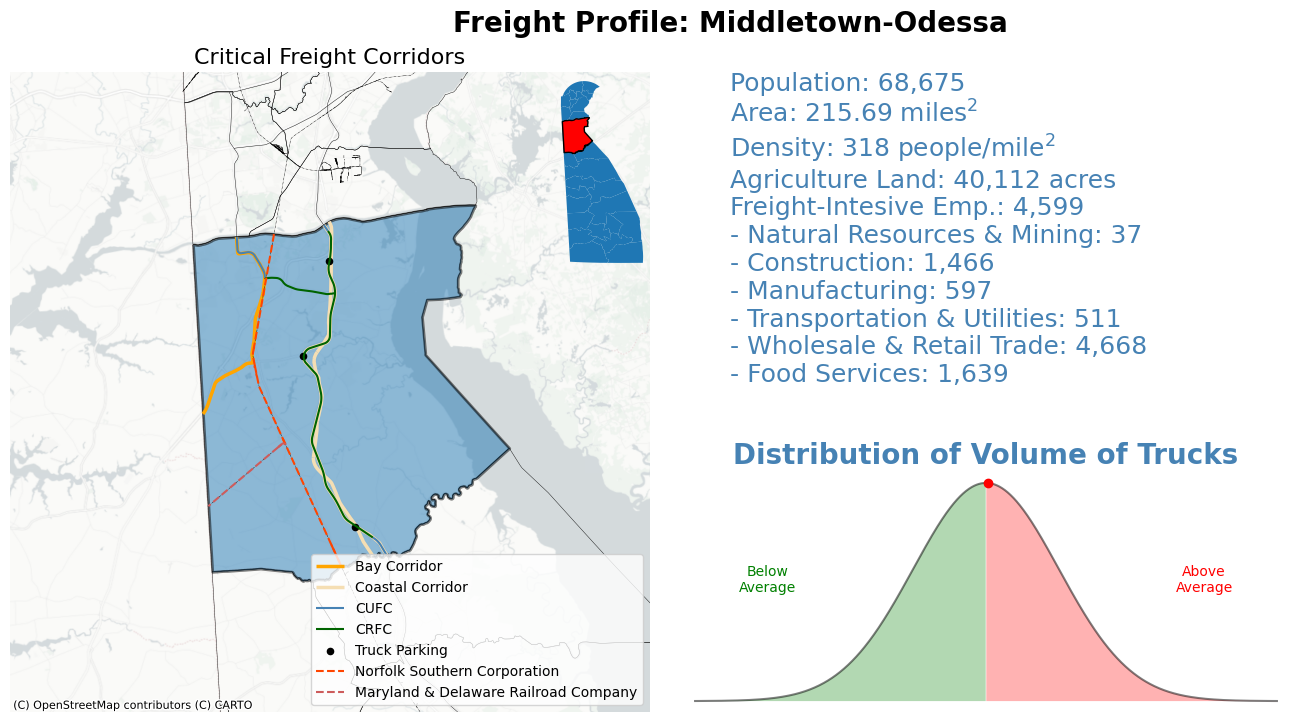

In [16]:
import warnings
# Ignore specific warning
warnings.filterwarnings("ignore", message="The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.")
# Ignore specific warning
warnings.filterwarnings("ignore", message="Only specify one of 'column' or 'color'. Using 'color'.")

CCD = "Middletown-Odessa"
resol = 85000
x_low = ccd[ccd["NAME"]==CCD].centroid.x.values[0] - resol
x_high = ccd[ccd["NAME"]==CCD].centroid.x.values[0] + resol
y_low = ccd[ccd["NAME"]==CCD].centroid.y.values[0] - resol
y_high = ccd[ccd["NAME"]==CCD].centroid.y.values[0] + resol

font = {'color':  'black',
        'weight': 'normal',
        'size': 16}
# [left, bottom, width, height]

fig = plt.figure(figsize=(16, 8))
ax = fig.add_axes([0.05, 0.05, 0.4, 0.8])

plt.title("Critical Freight Corridors", fontdict=font)
ccd.plot(facecolor = "none", lw = 0.3, ax=ax)
ccd[ccd["NAME"]==CCD].plot(alpha=0.5, edgecolor="k", lw = 2 , ax=ax)
CFC.plot(color="k", linestyle="-", lw = 0.3, ax=ax)
metro_intercept = gpd.overlay(MetroCorridor, ccd[ccd['NAME']==CCD],
                                how="intersection")
metro_intercept.plot(linestyle="-", ax=ax, lw = 2.5,
                             label = 'Metro Corridor', color="orange",
                             zorder=1);
piedmont_intercept = gpd.overlay(PiedmontCorridor, ccd[ccd['NAME']==CCD],
                                how="intersection")
piedmont_intercept.plot(linestyle="-", ax=ax, lw = 2.5,
                             label = 'Piedmont Corridor', color="orange",
                             zorder=1);
bay_intercept = gpd.overlay(BayCorridor, ccd[ccd['NAME']==CCD],
                                how="intersection")
bay_intercept.plot(linestyle="-", ax=ax, lw = 2.5,
                             label = 'Bay Corridor', color="orange",
                             zorder=1);
lewes_intercept = gpd.overlay(LewesCorridor, ccd[ccd['NAME']==CCD],
                                how="intersection")
lewes_intercept.plot(linestyle="-", ax=ax, lw = 2.5,
                             label = 'Lewes Corridor', color="orange",
                             zorder=1);
coastal_intercept = gpd.overlay(CoastalCorridor, ccd[ccd['NAME']==CCD],
                                how="intersection")
coastal_intercept.plot(linestyle="-", ax=ax, lw = 2.5,
                             label = 'Coastal Corridor', color="wheat",
                             zorder=1);
intersept = gpd.overlay(CFC, ccd[ccd["NAME"]==CCD], how="intersection")

intersept[intersept["FREIGHT_NE"]=='CUFC'].plot(linestyle="-", ax=ax,
                             label = 'CUFC', color="steelblue");
intersept[intersept["FREIGHT_NE"]== 'CRFC'].plot(linestyle="-", ax=ax,
                             label = 'CRFC', color="darkgreen");
intersept[intersept["FREIGHT_NE"]== 'PFN'].plot(linestyle="-", ax=ax,
                             label = 'PFN', color="peru");
bottleneck_intersect = gpd.overlay(FMB, ccd[ccd["NAME"]==CCD], how="intersection")
bottleneck_intersect.plot("ROADNAME", linestyle="-", ax=ax,
                             label = "Bottleneck", color="red");
rail.plot(color="k", linestyle="-.", lw = 0.3, ax=ax)


truck_parking_intercept = gpd.overlay(truck_parking, ccd[ccd["NAME"]==CCD], how="intersection")
truck_parking_intercept.geometry.centroid.plot(color="k", markersize=20, ax=ax, label="Truck Parking", zorder=1)
ax.legend(loc='lower right')


palette = ["orangered", "gold", "olive", "salmon", "tomato", "darksalmon",
           "coral", "indianred", "brown", "firebrick", "maroon"]

for i in range(len(rail["OWNER"].unique())):
  intersect_rail = gpd.overlay(rail[rail.OWNER==rail["OWNER"].unique()[i]], ccd[ccd["NAME"]==CCD], how="intersection");
  intersect_rail.plot("OWNER", linestyle="--", ax=ax, label = rail["OWNER"].unique()[i], color = palette[i]);

ax.set_xlim(x_low, x_high)
ax.set_ylim(y_low, y_high)
ax.set_axis_off()

ax2 = fig.add_axes([0.37, 0.60, 0.1, 0.25])
ccd.plot(ax=ax2)
ccd[ccd['NAME'] == CCD].plot(ax=ax2, color="r", edgecolor="k", lw = 1)
ax2.set_axis_off()

ax3 = fig.add_axes([0.460, 0.40, 0.4, 0.45])
ax3.set_axis_off()

ax4 = fig.add_axes([0.460, 0.05, 0.4, 0.3])
# prompt: plot a bell curve
# Define the x-axis values
x = np.linspace(-4, 4, 1000)
# Define the y-axis values using the normal distribution function
y = np.exp(-x**2 / 2) / (np.sqrt(2 * np.pi))
# The z-score
z = ccd[ccd["NAME"]==CCD]["z-score"].values[0]

# Create the plot
ax4.plot(x, y, alpha=0.5, color="k")

# Add labels and title
ax4.set_axis_off()
plt.title("Distribution of Volume of Trucks", color="steelblue", weight="bold", fontsize=20)

# Add a dot on the bell curve at x = 1
ax4.plot(z, np.exp(-z**2 / 2) / (np.sqrt(2 * np.pi)), marker="o", color="red")

# Fill the area under the curve with green color
ax4.fill_between(x, y, 0, where=x <= 0, facecolor="green", alpha=0.3)
ax4.fill_between(x, y, 0, where=x > 0, facecolor="red", alpha=0.3)
ax4.text(-3,0.2, "Below\nAverage", color="green", alpha=1, fontsize=10, ha="center")
ax4.text( 3,0.2, "Above\nAverage", color="red", alpha=1, fontsize=10, ha="center")

cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, crs = "EPSG:2235")
ax.legend(loc='lower right')

header = fig.text(0.5, 0.90, "Freight Profile: " + CCD, fontsize=20, color="k", weight="bold", ha="center")
content =  fig.text(0.5, 0.85,  "Population: " +  "{:,}".format(ccd[ccd["NAME"]==CCD]["POP_20"].values[0]) + "\n" +
                                "Area: " + "{:,.2f}".format(ccd[ccd["NAME"]==CCD].area.values[0]*3.58701e-8) + " miles$^2$\n" +
                                "Density: " + "{:,.0f}".format(ccd[ccd["NAME"]==CCD]["POP_20"].values[0] / ccd[ccd["NAME"]==CCD].area.values[0] / 3.58701e-8) + " people/mile$^2$\n" +
                                "Agriculture Land: " + "{:,.0f} acres".format(ccd[ccd["NAME"]==CCD]['AgLand_acres'].values[0]) + "\n" +
                                "Freight-Intesive Emp.: " + "{:,}".format(ccd[ccd["NAME"]==CCD]["FIS"].values[0]) + "\n" +
                                "- Natural Resources & Mining: " + "{:,}".format(ccd[ccd["NAME"]==CCD]['NATRES_20'].values[0]) + "\n" +
                                "- Construction: " + "{:,}".format(ccd[ccd["NAME"]==CCD]['CONS_20'].values[0]) + "\n" +
                                "- Manufacturing: " + "{:,}".format(ccd[ccd["NAME"]==CCD]['MANU_20'].values[0]) + "\n" +
                                "- Transportation & Utilities: " + "{:,}".format(ccd[ccd["NAME"]==CCD]['TRN_UTL_20'].values[0]) + "\n" +
                                "- Wholesale & Retail Trade: " + "{:,}".format(ccd[ccd["NAME"]==CCD]['WHL_RET_20'].values[0]) + "\n"
                                "- Food Services: " + "{:,}".format(ccd[ccd["NAME"]==CCD]['FOOD_SVC_2'].values[0]) + "\n"
                                , color="steelblue", weight="normal", va="top", fontsize=18)
fig.show()

In [9]:
ccd.columns

Index(['NAME', 'geometry', 'CCD', 'POP_20', 'TOT_Units_', 'Occ_HH_20',
       'Vacant_20', 'Tot_GC_20', 'TOT_Inst_2', 'TOT_nonins', 'NATRES_20',
       'CONS_20', 'MANU_20', 'WHL_RET_20', 'TRN_UTL_20', 'INFO_20',
       'FINANCE_20', 'PRO_BUS_20', 'ED_HEALTH_', 'LE_HOSP_20', 'OT_SVCS_20',
       'PUBADM_20', 'FOOD_SVC_2', 'FIS_20', 'TOT_20', 'EMP_19', 'Adj_EMP_20',
       'FIS', 'SIS', 'FIS_per', 'FIS_capita', 'AgLand_acres',
       'Destination Zone Name', 'Average Daily O-D Traffic (StL Index)',
       'z-score'],
      dtype='object')

In [ ]:
ccd_name = "tl_rd22_10_cousub (1)/tl_rd22_10_cousub.shp"
ccd2 =  gpd.read_file(dir + ccd_name)[["NAME", "geometry"]]
ccd2 = ccd2.to_crs("EPSG:2235")
truck_parking_temp = gpd.overlay(truck_parking, ccd2, how="intersection")
temp1 = truck_parking_temp.groupby("NAME").sum(numeric_only=True).reset_index()
temp2 = truck_parking_temp.groupby("NAME").count().reset_index()[["NAME", "Parking"]]
parking = temp1.merge(temp2, on="NAME")

ccd_updated = ccd.merge(parking, on="NAME", how="left")

In [ ]:
# Preparing for regressions

cols = ['CCD', 'POP_20', 'TOT_Units_', 'Occ_HH_20',
       'Vacant_20', 'Tot_GC_20', 'TOT_Inst_2', 'TOT_nonins', 'NATRES_20',
       'CONS_20', 'MANU_20', 'WHL_RET_20', 'TRN_UTL_20', 'INFO_20',
       'FINANCE_20', 'PRO_BUS_20', 'ED_HEALTH_', 'LE_HOSP_20', 'OT_SVCS_20',
       'PUBADM_20', 'FOOD_SVC_2', 'FIS_20', 'TOT_20', 'EMP_19', 'Adj_EMP_20',
       'FIS', 'SIS', 'Average Daily O-D Traffic (StL Index)', 'z-score', 'counts',
       'Parking']

ccd_updated = ccd_updated[cols]

In [ ]:
ccd_updated

,CCD,POP_20,TOT_Units_,Occ_HH_20,Vacant_20,Tot_GC_20,TOT_Inst_2,TOT_nonins,NATRES_20,CONS_20,...,FIS_20,TOT_20,EMP_19,Adj_EMP_20,FIS,SIS,Average Daily O-D Traffic (StL Index),z-score,counts,Parking
0,Lewes,38035,33243,18508,14735,256,219,37,19,853,...,12418,23246,25543,23246,8142,16262,NaN,NaN,NaN,NaN
1,Millsboro,34036,19009,14464,4545,294,281,13,2568,613,...,9794,13756,15114,13756,6095,4138,NaN,NaN,9.0,1.0
2,Central Kent,30144,11430,10884,546,23,0,23,16,282,...,682,2227,2750,2227,514,1631,NaN,NaN,NaN,NaN
3,Smyrna,29582,11325,10737,588,306,272,34,18,326,...,3273,6951,8583,6951,1519,3897,NaN,NaN,NaN,NaN
4,Middletown-Odessa,68675,23427,22558,869,2340,1737,603,37,1466,...,8906,18814,20702,18814,4599,9515,97381.0,0.026529,59.0,3.0
5,New Castle,90410,36383,34665,1718,618,510,108,54,2933,...,18037,35786,38545,35786,9350,17377,271318.0,2.458309,108.0,5.0
6,Pike Creek-Central Kirkwood,42813,18310,17596,714,536,229,307,0,559,...,4451,13844,14922,13844,2612,10735,33972.0,-0.859980,NaN,NaN
7,Wilmington,70742,33944,30043,3901,2372,1865,507,20,1290,...,12805,63376,68075,63376,8076,49654,168426.0,1.019796,68.0,4.0
8,Lower Christiana,37732,16096,15257,839,134,72,62,29,2989,...,12644,24741,26553,24741,9816,12441,66621.0,-0.403521,NaN,NaN
9,Piedmont,30937,12201,11655,546,838,806,32,10,398,...,2735,12071,14385,12071,2771,10166,31267.0,-0.897798,NaN,NaN


In [ ]:
# -- import statmodels using the formula api
import statsmodels.formula.api as sm

# -- first build the model
model = sm.ols("StL_Index ~ TOT_Units_ + FIS", data=ccd_updated)

# -- now fit the model to the data
result = model.fit()

# -- summarize the model fit
print(result.summary())

PatsyError: Error evaluating factor: NameError: name 'StL_Index' is not defined
    StL_Index ~ TOT_Units_ + FIS
    ^^^^^^^^^